In [1]:
import io
import os
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset, SequentialSampler
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import (set_seed,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          BertTokenizer,
                          BertForSequenceClassification)
from helper import b_metrics

seed = 1520
set_seed(seed)

In [2]:
path = "./smss/SMSSpamCollection"

val_ratio = 0.2

epochs = 4

batch_size = 32

# Text sequence length, will pad or truncate to the same size.
max_length = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "bert-base-uncased"

# 2 labels: negative and positive.
label_ids = {"spam": 0, "ham": 1}
ids_label = {0: "spam", 1: "ham"}

n_labels = len(label_ids)

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
model_tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_name,
    do_lower_case=True
)

model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels = n_labels,
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mod

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [4]:
texts = []
labels = []

with open(path) as f:
    for line in f.readlines():
        split = line.split('\t')
        # Save content.
        texts.append(split[1])
        # Save encode labels.
        labels.append(1 if split[0] == "spam" else 0)

token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_length,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in texts:
  encoding_dict = preprocessing(sample, model_tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest

In [5]:
# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def train(epoch, dataloader, optimizer, scheduler, device):
    # Take global model.
    global model

    # Tracking variables.
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    with tqdm(dataloader, total=len(dataloader), unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}/{epochs}")
        for batch in tepoch:

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()
            # Forward pass
            # TODO: Check what's the return structure looks like.
            train_output = model(
                b_input_ids, 
                token_type_ids = None, 
                attention_mask = b_input_mask, 
                labels = b_labels)
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            scheduler.step()
            # Update tracking variables
            loss = train_output.loss.item()
            total_loss += loss

            tepoch.set_postfix(loss=loss)
    
    avg_epoch_loss = total_loss / len(dataloader)

    return avg_epoch_loss

def validation(dataloader, device):
    global model

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    #total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluatdion.
    model.eval()

    with tqdm(dataloader, total=len(dataloader), unit="batch") as tepoch:
        for batch in tepoch:

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
                eval_output = model(
                    b_input_ids, 
                    token_type_ids = None, 
                    attention_mask = b_input_mask, 
                )
            logits = eval_output.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate validation metrics
            b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
            val_accuracy.append(b_accuracy)
            # Update precision only when (tp + fp) !=0; ignore nan
            if b_precision != 'nan': val_precision.append(b_precision)
            # Update recall only when (tp + fn) !=0; ignore nan
            if b_recall != 'nan': val_recall.append(b_recall)
            # Update specificity only when (tn + fp) !=0; ignore nan
            if b_specificity != 'nan': val_specificity.append(b_specificity)

    
    return val_accuracy, val_precision, val_recall, val_specificity
    
def inference(text):
    #TODO: fix
    global model

    token = model_tokenizer(
        text=[text], 
        return_tensors="pt",                    
        padding=True, 
        truncation=True,  
        max_length=max_length
    )
    token = token.to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(input_ids=token["input_ids"], attention_mask=token["attention_mask"])
        logits = outputs[0].detach().cpu().numpy()
        logits = logits.argmax(axis=-1)
    
    return ids_label[logits[0]]

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 35/35 [00:00<00:00, 69.84batch/s]



	 - Train loss: 15.3475
	 - Validation Accuracy: 0.9866
	 - Validation Precision: 0.9332
	 - Validation Recall: 0.9697
	 - Validation Specificity: 0.9896



100%|██████████| 35/35 [00:00<00:00, 69.43batch/s]



	 - Train loss: 1.7966
	 - Validation Accuracy: 0.9911
	 - Validation Precision: 0.9614
	 - Validation Recall: 0.9768
	 - Validation Specificity: 0.9938



100%|██████████| 35/35 [00:00<00:00, 68.70batch/s]



	 - Train loss: 0.5333
	 - Validation Accuracy: 0.9884
	 - Validation Precision: 0.9444
	 - Validation Recall: 0.9768
	 - Validation Specificity: 0.9906



100%|██████████| 35/35 [00:00<00:00, 68.67batch/s]
/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',



	 - Train loss: 0.1759
	 - Validation Accuracy: 0.9938
	 - Validation Precision: 0.9816
	 - Validation Recall: 0.9711
	 - Validation Specificity: 0.9980



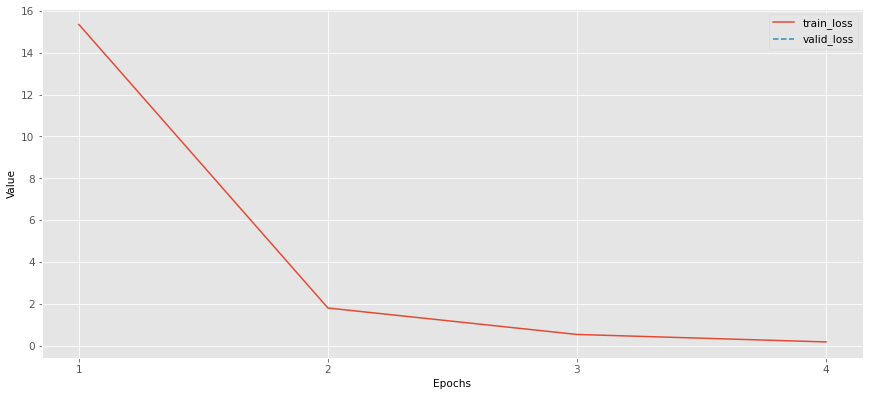

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


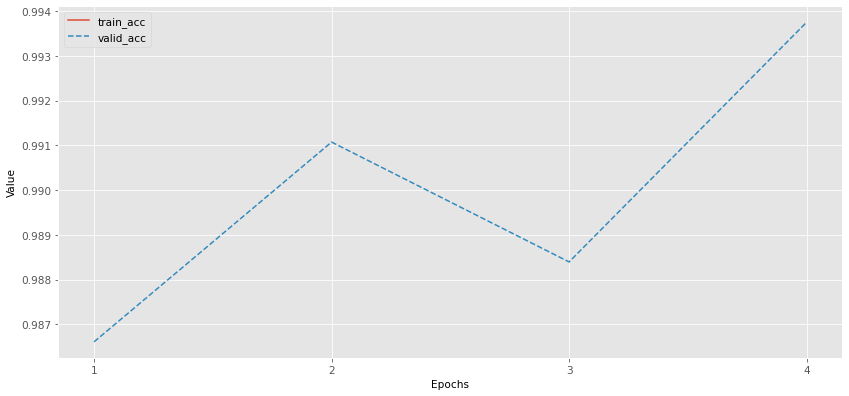

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


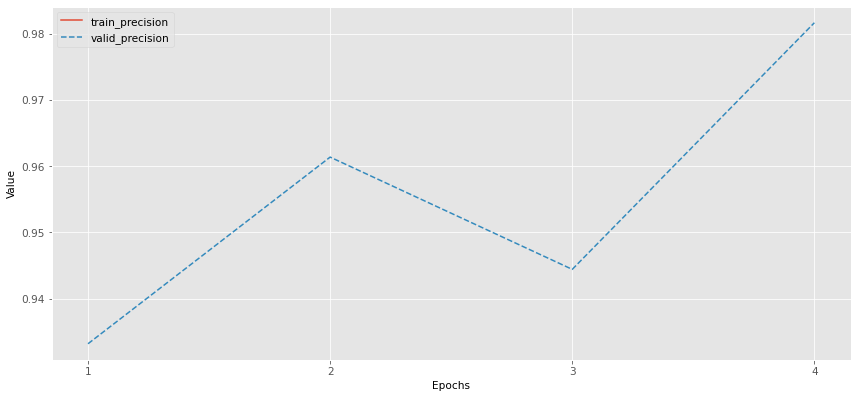

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


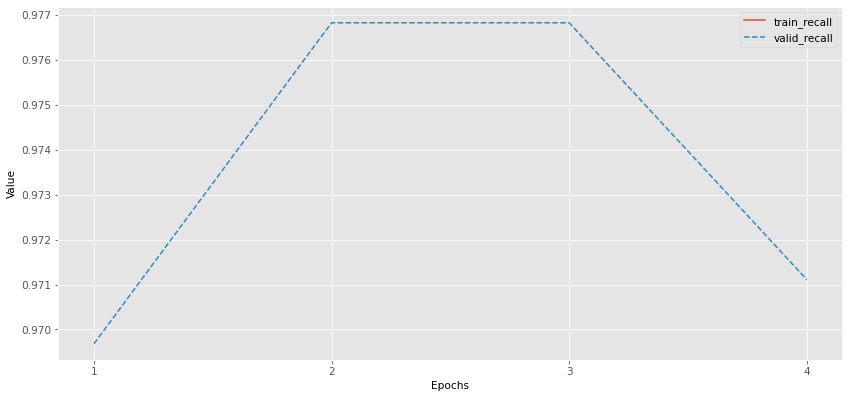

/home/stu00608/miniconda3/envs/ml/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


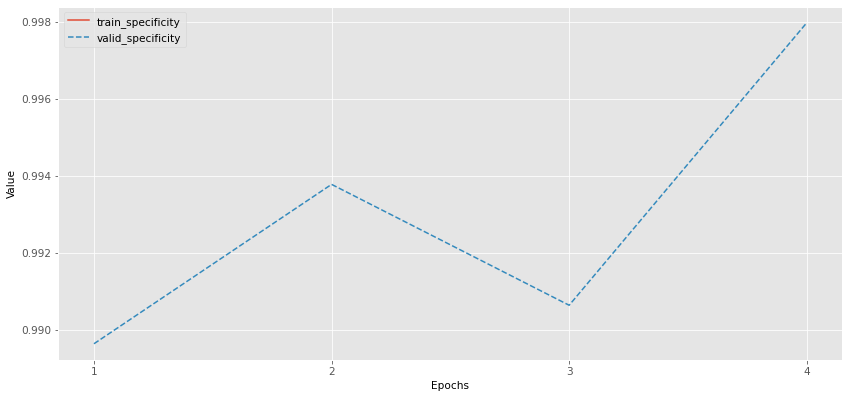

In [7]:
total_steps = len(train_dataloader) * epochs

optimizer = AdamW(
    model.parameters(),
    lr = 2e-5, # default is 5e-5, our notebook had 2e-5
    eps = 1e-8 # default is 1e-8.
)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Metrics
all_loss = {
    "train_loss": [],
    "valid_loss": []
}
all_acc = {
    "train_acc": [],
    "valid_acc": []
}
all_precision = {
    "train_precision": [],
    "valid_precision": []
}
all_recall = {
    "train_recall": [],
    "valid_recall": []
}
all_specificity = {
    "train_specificity": [],
    "valid_specificity": []
}

for epoch in range(1, epochs+1):
    train_loss = train(epoch, train_dataloader, optimizer, scheduler, device)

    val_accuracy, val_precision, val_recall, val_specificity = validation(
        validation_dataloader,
        device
    )

    epoch_loss = train_loss / epoch*len(train_dataloader)
    epoch_acc = sum(val_accuracy)/len(val_accuracy)
    epoch_precision = sum(val_precision)/len(val_precision)
    epoch_recall = sum(val_recall)/len(val_recall)
    epoch_specificity = sum(val_specificity)/len(val_specificity)

    all_loss['train_loss'].append(epoch_loss) 
    all_acc['valid_acc'].append(epoch_acc)
    all_precision['valid_precision'].append(epoch_precision)
    all_recall['valid_recall'].append(epoch_recall)
    all_specificity['valid_specificity'].append(epoch_specificity)

    print('\n\t - Train loss: {:.4f}'.format(epoch_loss))
    print('\t - Validation Accuracy: {:.4f}'.format(epoch_acc))
    print('\t - Validation Precision: {:.4f}'.format(epoch_precision) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(epoch_recall) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(epoch_specificity) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


plot_dict(all_loss, use_xlabel="Epochs", use_ylabel="Value", use_linestyles=['-', '--'])
plot_dict(all_acc, use_xlabel="Epochs", use_ylabel="Value", use_linestyles=['-', '--'])
plot_dict(all_precision, use_xlabel="Epochs", use_ylabel="Value", use_linestyles=['-', '--'])
plot_dict(all_recall, use_xlabel="Epochs", use_ylabel="Value", use_linestyles=['-', '--'])
plot_dict(all_specificity, use_xlabel="Epochs", use_ylabel="Value", use_linestyles=['-', '--'])